In [1]:
import tensorboard as tb
import tensorflow as tf
print(tf.__version__)

2024-08-20 11:46:53.166959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
import pandas as pd

In [3]:
summary_dir = "../system/controller/reachability_estimator/runs/"

In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

COMPUTER = 'lxhalle.stud.rbg.tum.de'
DATASET_FEATURES = ''

from collections import defaultdict
Features = str
Date = str
Metric = str
data: dict[Date, dict[Features, dict[Metric, float]]] = defaultdict(lambda: defaultdict(dict))

for event_file in os.listdir(summary_dir):
    date, time, descr = event_file.split('_', maxsplit=2)
    if not descr.startswith(COMPUTER):
        continue
    descr = descr.removeprefix(COMPUTER)
    descr = descr.split('+')
    #features, *descr = descr
    #if features != DATASET_FEATURES:
    #    continue
    event_file = os.path.join(summary_dir, event_file)
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()
    #print(date, time, descr)
    date = date + '/T' + time[:2]
    descr = data[date][tuple(descr)]
    for tagtype, tags in event_acc.Tags().items():
        if 'graph' in tagtype:
            continue
        for tag in tags:
            events = getattr(event_acc, tagtype.title())(tag)
            descr[tag] = events[-1].value
            #print(tagtype, tag, ':', events[-1].value, 'events')

In [20]:
def only_default_features(features):
    if 'crop' in ''.join(features):
        return False
    return True

def filter_runs(data, date_filter=lambda data:True, feature_filter=only_default_features, by_feature=None):
    result: dict[str, tuple[list, list, ]] = defaultdict(lambda: ([], []))

    for date in data.keys():
        if not date_filter(date):
            continue
        data[date] = dict(data[date])
        scores = []
        features = []
        for feature in data[date]:
            if not feature_filter(feature):
                continue
            data[date][feature] = dict(data[date][feature])
            try:
                score = data[date][feature]['Metrics/Fscore']
            except KeyError:
                continue
            #if 'fc256,128,64,32,16' not in feature:
            #    feature = list(feature)
            #    feature.remove('fc256,128,64,32,16')
            #    feature = tuple(feature)
            if by_feature == 'date':
                label = date
            elif by_feature == None:
                label = None
            else:
                label = by_feature in feature
                if by_feature in feature:
                    feature = list(feature); feature.remove(by_feature); feature = tuple(feature)
            result[label][0].append('+'.join(feature))
            result[label][1].append(score)
    result = dict(result)
    return result

import matplotlib.pyplot as plt

def plot_runs(data, invert_axes=False):
    fig, ax = plt.subplots()
    for labeli, (xi, yi) in data.items():
        if len(xi) == 0:
            continue # avoid plotting empty series that still shows up in the legend
        if invert_axes:
            ax.scatter(yi, xi, label=labeli)
            ax.set_xlabel('F1-score')
            ax.set_xlim(0, 1)
        else:
            ax.scatter(xi, yi, label=labeli)
            ax.set_ylabel('F1-score')
            ax.set_ylim(0, 1)
            fig.autofmt_xdate()
        if len(data) > 1:
            fig.legend()
    ax.set_yticklabels(ax.get_yticklabels(), ha='right')
    fig.tight_layout()
    return fig

# Some plots

[0.0008328579133376479, 0.14382438361644745, 0.05635328218340874]

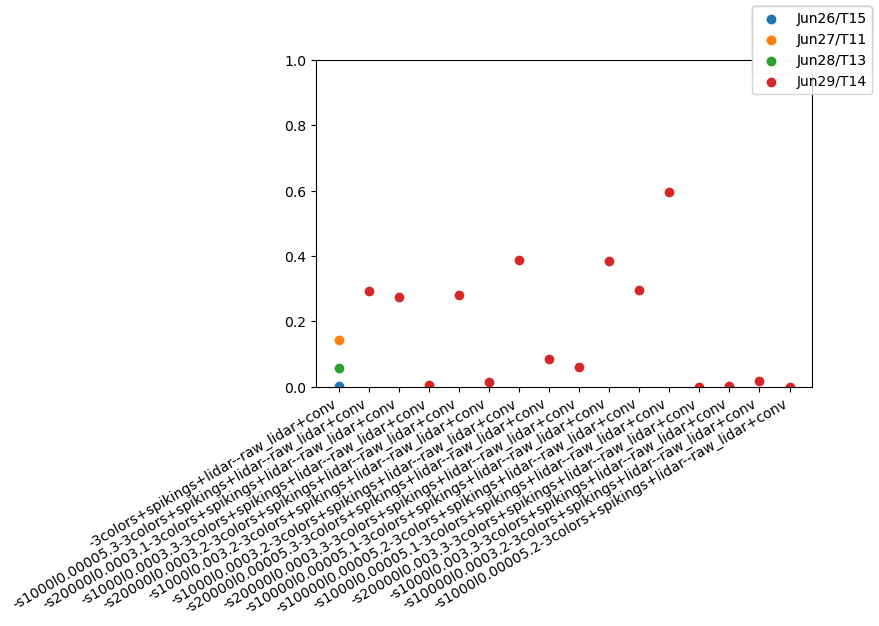

In [6]:
runs = filter_runs(
    data,
    lambda date: date[:3] == 'Jun',
    lambda features: '-3colors+spikings+lidar--raw_lidar+conv' in '+'.join(features),
    by_feature='date'
)
_fig = plot_runs(runs)
features = '-3colors+spikings+lidar--raw_lidar+conv'
baseline = [r for r in runs.values() if features in r[0]]
baseline = [ r[1][r[0].index(features)] for r in baseline ]
baseline

\begin{tabular}{rrrr}
\toprule
Samples per epoch & Learning rate & Maximum F1-score & Minimum F1-score \\
\midrule
1000 & 0.000050 & 0.595768 & 0.000128 \\
1000 & 0.000300 & 0.386990 & 0.005826 \\
1000 & 0.003000 & 0.015203 & 0.002473 \\
10000 & 0.000050 & 0.385065 & 0.296099 \\
10000 & 0.000300 & 0.016569 & 0.016569 \\
10000 & 0.003000 & 0.143824 & 0.000833 \\
20000 & 0.000050 & 0.083240 & 0.083240 \\
20000 & 0.000300 & 0.281858 & 0.060378 \\
20000 & 0.003000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



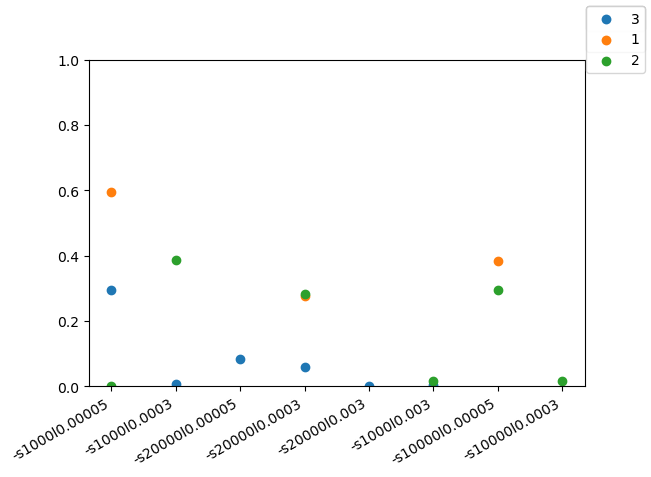

In [7]:
runs = filter_runs(data, feature_filter=lambda feats: '-s' in ''.join(feats), by_feature='date')
assert len(runs) == 1
runs = runs['Jun29/T14']
new_runs = defaultdict(lambda: ([], []))
for tags, val in zip(runs[0], runs[1]):
    suffix = '-3colors+spikings+lidar--raw_lidar+conv'
    assert tags.endswith(suffix); tags = tags.removesuffix(suffix)
    tags, attempt = tags[:-2], int(tags[-1])
    column = new_runs[str(attempt)]
    column[0].append(tags)
    column[1].append(val)
_fig = plot_runs(new_runs)

performance_by_config = defaultdict(lambda: [])
for _attempt, (tags, values) in new_runs.items():
    for tag, value in zip(tags, values):
        performance_by_config[tag].append(value)
performance_by_config = dict(performance_by_config)
performance = { key: values for key, values in performance_by_config.items() }

def iefe():
    for key, value in performance.items():
        assert key[:2] == '-s'; key = key.removeprefix('-s')
        samples_per_epoch, learning_rate = key.split('l')
        yield {'Samples per epoch': int(samples_per_epoch), 'Learning rate': float(learning_rate), 'Maximum F1-score': max(value), 'Minimum F1-score': min(value)}
df = list(iefe())
df.append({ 'Samples per epoch': 10000, 'Learning rate': 0.003, 'Maximum F1-score': max(baseline), 'Minimum F1-score': min(baseline) })

import pandas as pd
df = pd.DataFrame.from_records(df)
pd.set_option('display.float_format', '{:.2g}'.format)
print(df.sort_values(by=['Samples per epoch', 'Learning rate']).to_latex(index=False))

/tmp/ipykernel_20157/3508646441.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), ha='right')


<Figure size 640x480 with 0 Axes>

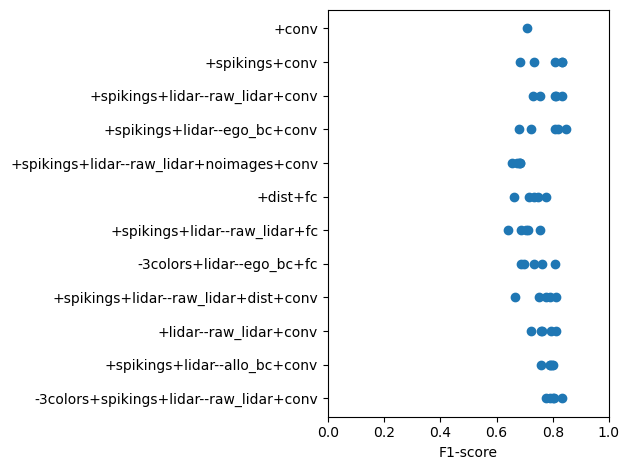

In [27]:
suitable_date = lambda date: (date[:3] == 'Jul' and int(date[3:5]) >= 24) or date[:3] == 'Aug'
#suitable_date = lambda date: date != 'Jul05/T13'

#x, y, labels = filter_runs(data, date_filter=suitable_date, feature_filter=lambda features:'crop' in ''.join(features))
#fig = plot_runs(x, y)
#fig.savefig('../../report/figures/train_results_crop.pgf')

plt.subplots_adjust(left=0.25)
plt.rc('ytick', labelsize=10)  # Set a consistent label size
runs = filter_runs(data, suitable_date)
_fig = plot_runs(runs, invert_axes=True)

In [28]:
_fig.savefig('../../report/figures/train_results.pgf', bbox_inches='tight')
!sed -i 's/_/\\_/g' ../../report/figures/train_results.pgf

In [23]:
def average(li):
    return sum(li) / len(li)

def get_performance(feature):
    with_ = average(feature[True][1])
    without = average(feature[False][1])
    return f'{without:.3f} -> {with_:.3f}: {with_ - without:.3f}'

'0.145 -> 0.009: -0.135'

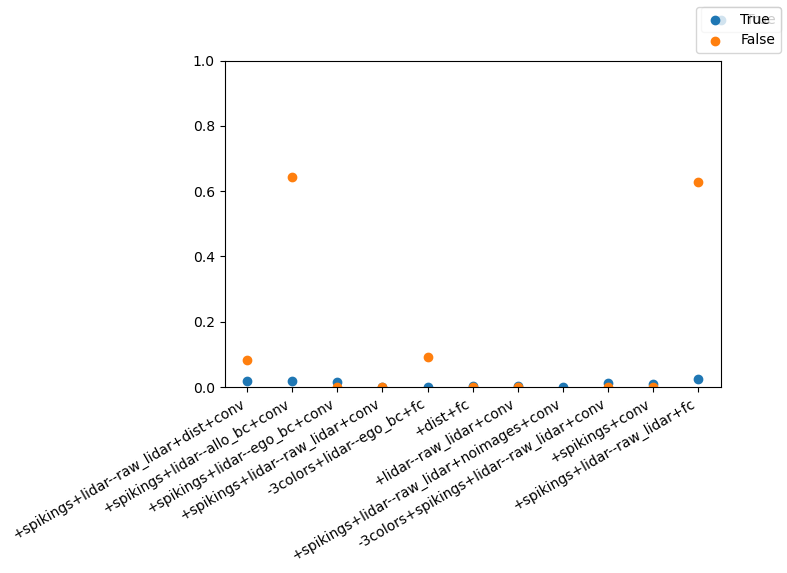

In [54]:
runs = filter_runs(
    data,
    lambda date: date in ('Jul05/T13', 'Jul04/T19'),
    #lambda features: ('dropout' in ''.join(features)),
    by_feature = 'dropout',
)
fig = plot_runs(runs)
get_performance(runs)

'0.116 -> 0.313: 0.197'

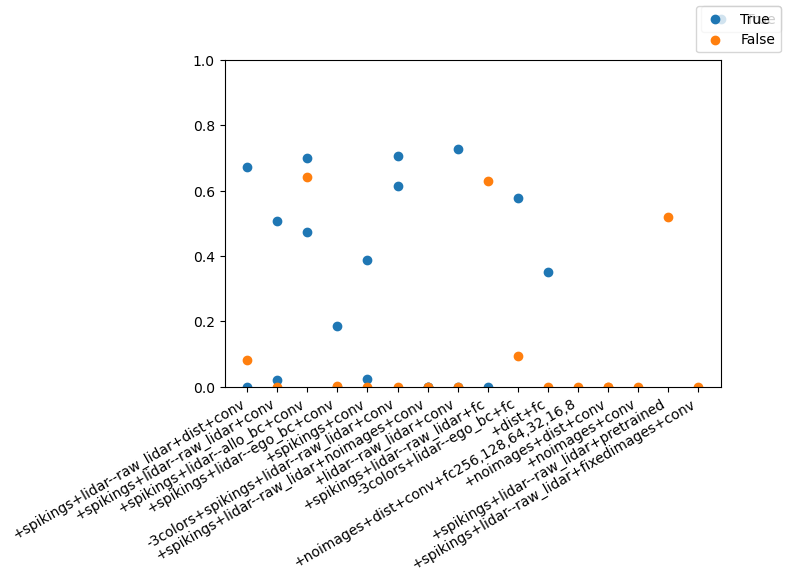

In [56]:
runs = filter_runs(
    data,
    lambda date: date[0:3] == 'Jul' and int(date[3:5]) < 5,
    by_feature='fc256,128,64,32,16',
)
fig = plot_runs(runs)
get_performance(runs)

#### Cropping images

\begin{tabular}{lr}
\toprule
Image cropping rule & F1-score \\
\midrule
No cropping & 0.706751 \\
X20 & 0.688021 \\
X10 & 0.630235 \\
N20 & 0.623460 \\
N10 & 0.597295 \\
\bottomrule
\end{tabular}



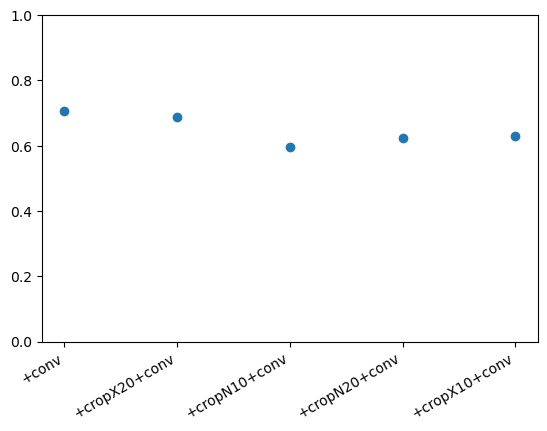

In [20]:
runs = filter_runs(
    data,
    lambda date: date.startswith('Aug12'),
    lambda feats: True,
    by_feature='date',
)
fig = plot_runs(runs)
runs = runs['Aug12/T12']
def parse(tags):
    assert tags.endswith('+conv'); tags = tags.removesuffix('+conv')
    if not tags:
        return 'No cropping'
    else:
        assert tags.startswith('+crop'); return tags.removeprefix('+crop')

df = pd.DataFrame({ 'Image cropping rule': map(parse, runs[0]), 'F1-score': runs[1]})
print(df.sort_values(by='F1-score', ascending=False).to_latex(index=False))

In [29]:
from collections import defaultdict
values_by_date: dict[Features, list[Metric]] = defaultdict(list)
for xi, yi in zip(x, y):
    for xij, yij in zip(xi, yi):
        values_by_date[xij].append(yij)
assert labels == ['Jul24/T16', 'Jul25/T09']
obsolete = []
for features, values in values_by_date.items():
    assert len(values) == 2, values
    if values[0] < values[1]:
        obsolete.append(features)
print(' '.join(obsolete))

AssertionError: 

In [30]:
values = defaultdict(list)
for xi, yi, labeli in zip(x, y, labels):
    for tag, value in zip(xi, yi):
        values[tag].append(value)

In [39]:
default_config = {'spikings', 'conv'}
def pretty_tag(tag):
    pretty = []
    tag = set(tag.split('+'))
    if '-3colors' in tag:
        pretty.append('3 wall colors')
        tag.remove('-3colors')
    else:
        tag.remove('')
    lidar = next(filter(lambda s: s.startswith('lidar--'), tag), None)
    if lidar is None:
        pretty.append('no lidar')
    else:
        tag.remove(lidar)
        lidar = lidar.removeprefix('lidar--')
        if lidar != 'raw_lidar':
            lidar = lidar.removesuffix('_bc')
            pretty.append(lidar + 'centric BVC spikings instead of lidar')
    if 'conv' in tag:
        tag.remove('conv')
    else:
        pretty.append('fully connected image encoder')
        tag.remove('fc')
    if 'spikings' in tag:
        tag.remove('spikings')
    else:
        pretty.append('GC spikings not provided')
    if 'dist' in tag:
        pretty.append('distance provided')
        tag.remove('dist')
    if 'noimages' in tag:
        pretty.append('images not provided')
        tag.remove('noimages')
    assert len(tag) == 0, tag
    if len(pretty) == 0:
        pretty = ['Default']
    return pretty

import pandas as pd
#tags = [', '.join(pretty_tag(tag)) for tag in values.keys()]
tags = values.keys()
#assert all(map(lambda i: i==5, map(len, values.values())))
df = pd.DataFrame({ 'tags': tags, 'max': map(max, values.values())})
df.sort_values(by='max', ascending=False)

,tags,max
0,+cropX20+conv,0.786467
3,+cropX10+conv,0.748703
2,+cropN20+conv,0.647837
1,+cropN10+conv,0.616498


In [40]:
print(df.sort_values(by='max', ascending=False).to_latex(index=False))

\begin{tabular}{lr}
\toprule
tags & max \\
\midrule
+cropX20+conv & 0.786467 \\
+cropX10+conv & 0.748703 \\
+cropN20+conv & 0.647837 \\
+cropN10+conv & 0.616498 \\
\bottomrule
\end{tabular}



In [9]:
baseline = df[df['tags'] == 'spikings+lidar--raw_lidar+conv']['max']
baseline = next(iter(baseline))
df['max'] = df['max'] - baseline
df

StopIteration: 

In [6]:
relevant_series = filter(lambda tup: tup[2] in ['Jul10/T10', 'Jul08/T18', 'Jul05/T19'], zip(x, y, labels))
relevant_series = list(relevant_series)
relevant_series

[(['spikings+lidar--raw_lidar+fc',
   'spikings+lidar--raw_lidar+noimages+conv',
   'dist+fc',
   'spikings+lidar--raw_lidar+dist+conv',
   'spikings+lidar--raw_lidar+conv',
   'lidar--raw_lidar+conv',
   'spikings+conv',
   'spikings+lidar--ego_bc+conv'],
  [0.6643402576446533,
   0.0007231528288684785,
   0.5362153053283691,
   0.5430660843849182,
   0.7349265217781067,
   0.7282484769821167,
   0.47915971279144287,
   0.4768792390823364],
  'Jul10/T10'),
 (['spikings+lidar--allo_bc+conv',
   'lidar--raw_lidar+conv',
   'spikings+lidar--raw_lidar+dist+conv',
   'spikings+lidar--raw_lidar+conv',
   'spikings+lidar--raw_lidar+fc',
   'spikings+lidar--ego_bc+conv',
   'spikings+conv',
   'dist+fc',
   'spikings+lidar--raw_lidar+noimages+conv'],
  [0.6391246914863586,
   0.7310674786567688,
   0.5446760058403015,
   0.7338154911994934,
   0.6639044880867004,
   0.47912880778312683,
   0.47506582736968994,
   0.5307824015617371,
   0.0006844444433227181],
  'Jul08/T18')]

In [7]:
from collections import defaultdict

results = defaultdict(dict)
for tags, values, date in relevant_series:
    for tag, value in zip(tags, values):
        results[tag][date] = value
print(f'     \tJul10/T10\tJul08/T18')
for tag, values in results.items():
    print(f'{tag}:\t{values.get('Jul10/T10', '??')}\t{values.get('Jul08/T18', '??')}')

     	Jul10/T10	Jul08/T18
spikings+lidar--raw_lidar+fc:	0.6643402576446533	0.6639044880867004
spikings+lidar--raw_lidar+noimages+conv:	0.0007231528288684785	0.0006844444433227181
dist+fc:	0.5362153053283691	0.5307824015617371
spikings+lidar--raw_lidar+dist+conv:	0.5430660843849182	0.5446760058403015
spikings+lidar--raw_lidar+conv:	0.7349265217781067	0.7338154911994934
lidar--raw_lidar+conv:	0.7282484769821167	0.7310674786567688
spikings+conv:	0.47915971279144287	0.47506582736968994
spikings+lidar--ego_bc+conv:	0.4768792390823364	0.47912880778312683
spikings+lidar--allo_bc+conv:	??	0.6391246914863586


# Validation

/tmp/ipykernel_3833696/3508646441.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), ha='right')


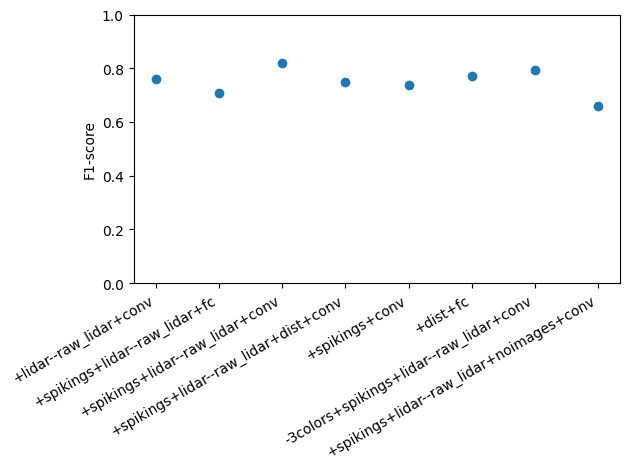

In [12]:
runs = filter_runs(
    data,
    lambda date: date == 'Aug27/T13',
)
_fig = plot_runs(runs)

In [13]:
xsim = []
xsim2 = []

training = runs[None][1]

for tags in runs[None][0]:
    net_file = '../system/controller/reachability_estimator/data/models/reachability_network' + tags + '.25'
    filename = '../system/controller/reachability_estimator/logs/SimulationRExNetworkRE(reachability_network' + tags + '.25).log'
    for suffix, li in zip(('', '.bak'), (xsim, xsim2)):
        with open(filename + suffix) as file:
            content = file.read()
        value = next(filter(lambda line: line.startswith('F1Score: '), content.split('\n')))
        value = value.removeprefix('F1Score: ')
        value = float(value)
        li.append(value)

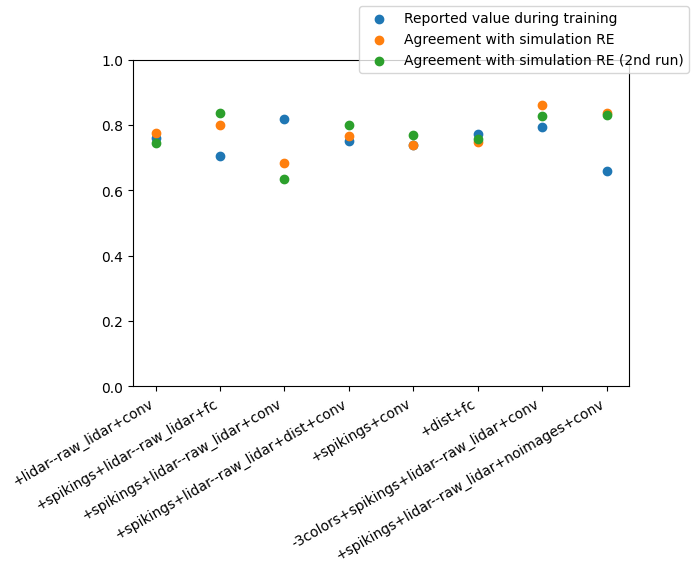

In [19]:
import matplotlib.pyplot as plt
tags = runs[None][0]
fig, ax = plt.subplots()
ax.scatter(tags, training, label='Reported value during training')
ax.scatter(tags, xsim, label='Agreement with simulation RE')
ax.scatter(tags, xsim2, label='Agreement with simulation RE (2nd run)')
ax.set_ylim((0, 1))
fig.autofmt_xdate()
fig.legend()

(0.0, 1.0)

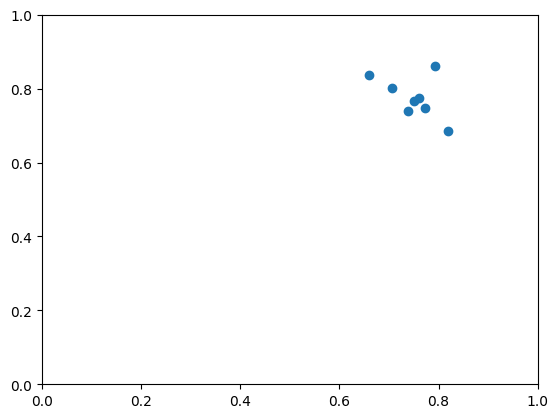

In [15]:
plt.scatter(training, xsim)
plt.xlim((0, 1))
plt.ylim((0, 1))

In [9]:
runs

{'Aug27/T13': (['+lidar--raw_lidar+conv',
   '+spikings+lidar--raw_lidar+fc',
   '+spikings+lidar--raw_lidar+conv',
   '+spikings+lidar--raw_lidar+dist+conv',
   '+spikings+conv',
   '+dist+fc',
   '-3colors+spikings+lidar--raw_lidar+conv',
   '+spikings+lidar--raw_lidar+noimages+conv'],
  [0.7597777247428894,
   0.7061499953269958,
   0.8194970488548279,
   0.7499122023582458,
   0.7381911277770996,
   0.7726017236709595,
   0.7932508587837219,
   0.6597123742103577])}